In [10]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import random

In [11]:
def set_all_seeds(RANDOM_SEED):
    random.seed(RANDOM_SEED)     # python random generator
    np.random.seed(RANDOM_SEED)  # numpy random generator

    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(42)

In [12]:

class SimpleCIFAR10Classifier(nn.Module):
    def __init__(self):
        super(SimpleCIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [13]:
# useful libraries
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##################
# YOUR CODE HERE #
##################

# adjust batch size to your need
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_size = int(0.5 * len(testset))
test_size = len(testset) - val_size

generator = torch.Generator().manual_seed(42)
valset, testset = torch.utils.data.random_split(testset, [val_size, test_size], generator=generator)


val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(trainset), len(valset), len(testset))

Files already downloaded and verified
Files already downloaded and verified
50000 5000 5000


# (a)

In [14]:
net = SimpleCIFAR10Classifier().cuda()
INITIAL_LR = 0.01
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"
best_val_acc = 0

# Training Loop
train_losses = []
val_losses = []
for i in range(0, EPOCHS):

    net.train()

    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    # Record training loss
    train_loss = 0

    # Looping through training loader
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ##################
        # YOUR CODE HERE #
        ##################

        # Send input and target to device
        inputs, targets = inputs.cuda(), targets.cuda()

        # compute the model output logits and training loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # backpropagation & optimizer update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate predictions
        predictions = outputs.argmax(1)
        correct_examples += (predictions == targets).sum().item()
        total_examples += inputs.shape[0]

    # calculate average training loss and accuracy
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_losses.append(avg_loss)


    # Evaluate the validation set performance
    net.eval()

    total_examples = 0
    correct_examples = 0

    # Record validation loss
    val_loss = 0

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ##################
            # YOUR CODE HERE #
            ##################

            # Send input and target to device
            inputs, targets = inputs.cuda(), targets.cuda()

            # compute the model output logits and validation loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            # count the number of correctly predicted samples in the current batch
            predictions = outputs.argmax(1)
            correct_examples += (predictions == targets).sum().item()
            total_examples += targets.size(0)


    current_learning_rate = optimizer.param_groups[0]['lr']

    # calculate average validation loss and accuracy
    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    val_losses.append(avg_loss)

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc

        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'best_model.bin'))

    print('')

print(f"Best validation accuracy: {best_val_acc:.4f}")

Epoch 0:
Training loss: 2.0584, Training accuracy: 0.2435
Validation loss: 1.6038, Validation accuracy: 0.4304
Saving ...

Epoch 1:
Training loss: 1.5072, Training accuracy: 0.4513
Validation loss: 1.4055, Validation accuracy: 0.4962
Saving ...

Epoch 2:
Training loss: 1.3155, Training accuracy: 0.5298
Validation loss: 1.2566, Validation accuracy: 0.5598
Saving ...

Epoch 3:
Training loss: 1.1864, Training accuracy: 0.5764
Validation loss: 1.1895, Validation accuracy: 0.5864
Saving ...

Epoch 4:
Training loss: 1.0970, Training accuracy: 0.6094
Validation loss: 1.1634, Validation accuracy: 0.6020
Saving ...

Epoch 5:
Training loss: 1.0138, Training accuracy: 0.6409
Validation loss: 1.1001, Validation accuracy: 0.6150
Saving ...

Epoch 6:
Training loss: 0.9508, Training accuracy: 0.6641
Validation loss: 1.0229, Validation accuracy: 0.6508
Saving ...

Epoch 7:
Training loss: 0.8967, Training accuracy: 0.6834
Validation loss: 1.0153, Validation accuracy: 0.6456

Epoch 8:
Training loss: 0.8

# (b)

In [15]:
##################
# YOUR CODE HERE #
##################

# load trained model weight

checkpoint_path = os.path.join(CHECKPOINT_FOLDER, 'best_model.bin')
checkpoint = torch.load(checkpoint_path)
net = SimpleCIFAR10Classifier().cuda()
net.load_state_dict(checkpoint['state_dict'])
net.eval()

SimpleCIFAR10Classifier(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
##################
# YOUR CODE HERE #
##################

# write a loop to evaluate trained model performance on the test split
test_total_examples = 0
test_correct_examples = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        predictions = outputs.argmax(1)
        test_correct_examples += (predictions == targets).sum().item()
        test_total_examples += inputs.shape[0]

test_accuracy = test_correct_examples / test_total_examples
print("Test accuracy: %.4f" % test_accuracy)

Test accuracy: 0.6668


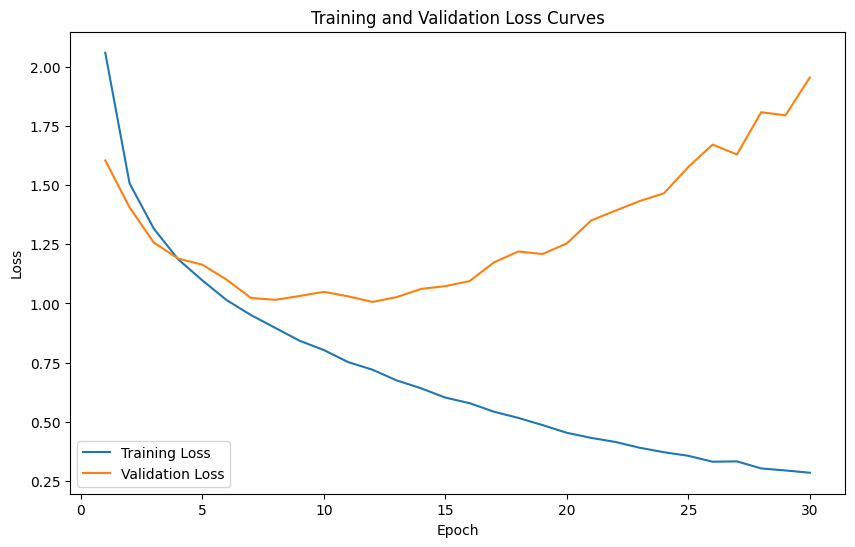

In [17]:
##################
# YOUR CODE HERE #
##################

# visualize model loss curves (both train and loss)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

This model is overfitting because although Training Loss is decreasing in the second half of training, Validation Loss is increasing.

# (C)

### L1 Regularization

In [18]:
INITIAL_LR = 0.01
net = SimpleCIFAR10Classifier().cuda()
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

##################
# YOUR CODE HERE #
##################

# set your L1 regularization weight
REG = 1e-4

# write training loops with L1 regularization and validation loops (Hint: similar to (a))
best_val_acc = 0

# Define the loss function with L1 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM)

# Training Loop with L1 regularization
train_losses = []
val_losses = []

for i in range(0, EPOCHS):
    net.train()
    print("Epoch %d:" % i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss_ce = criterion(outputs, targets)

        l1_reg = torch.tensor(0., device='cuda')
        for param in net.parameters():
            l1_reg += torch.norm(param, 1)

        loss = loss_ce + REG * l1_reg

        loss.backward()
        optimizer.step()

        predictions = outputs.argmax(1)
        correct_examples += (predictions == targets).sum().item()
        total_examples += inputs.shape[0]

        train_loss += loss.item()

    current_learning_rate = optimizer.param_groups[0]['lr']
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))
    train_losses.append(avg_loss)

    net.eval()
    total_examples = 0
    correct_examples = 0
    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # Send input and target to device
            inputs, targets = inputs.cuda(), targets.cuda()

            # compute the model output logits and validation loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            # count the number of correctly predicted samples in the current batch
            predictions = outputs.argmax(1)
            correct_examples += (predictions == targets).sum().item()
            total_examples += targets.size(0)

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    val_losses.append(avg_loss)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc

        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'best_model_l1.bin'))
    print('')

print(f"Best validation accuracy (with L1 regularization): {best_val_acc:.4f}")

Epoch 0:
Training loss: 2.2907, Training accuracy: 0.2173
Validation loss: 1.7476, Validation accuracy: 0.3676
Saving ...

Epoch 1:
Training loss: 1.7409, Training accuracy: 0.4263
Validation loss: 1.4921, Validation accuracy: 0.4618
Saving ...

Epoch 2:
Training loss: 1.5555, Training accuracy: 0.4953
Validation loss: 1.3141, Validation accuracy: 0.5214
Saving ...

Epoch 3:
Training loss: 1.4312, Training accuracy: 0.5453
Validation loss: 1.2054, Validation accuracy: 0.5726
Saving ...

Epoch 4:
Training loss: 1.3400, Training accuracy: 0.5806
Validation loss: 1.1984, Validation accuracy: 0.5730
Saving ...

Epoch 5:
Training loss: 1.2617, Training accuracy: 0.6088
Validation loss: 1.1676, Validation accuracy: 0.5860
Saving ...

Epoch 6:
Training loss: 1.2199, Training accuracy: 0.6304
Validation loss: 1.0780, Validation accuracy: 0.6226
Saving ...

Epoch 7:
Training loss: 1.1640, Training accuracy: 0.6488
Validation loss: 1.0842, Validation accuracy: 0.6218

Epoch 8:
Training loss: 1.1

In [19]:
##################
# YOUR CODE HERE #
##################

# load trained model weight
checkpoint_path = os.path.join(CHECKPOINT_FOLDER, 'best_model_l1.bin')
checkpoint = torch.load(checkpoint_path)

net = SimpleCIFAR10Classifier().cuda()
net.load_state_dict(checkpoint['state_dict'])
net.eval()

SimpleCIFAR10Classifier(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [20]:
##################
# YOUR CODE HERE #
##################

# write another loop to evaluate trained model performance on the test split
test_total_examples = 0
test_correct_examples = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        predictions = outputs.argmax(1)
        test_correct_examples += (predictions == targets).sum().item()
        test_total_examples += inputs.shape[0]

test_accuracy = test_correct_examples / test_total_examples
print("Test accuracy (with L1 regularization): %.4f" % test_accuracy)

Test accuracy (with L1 regularization): 0.6632


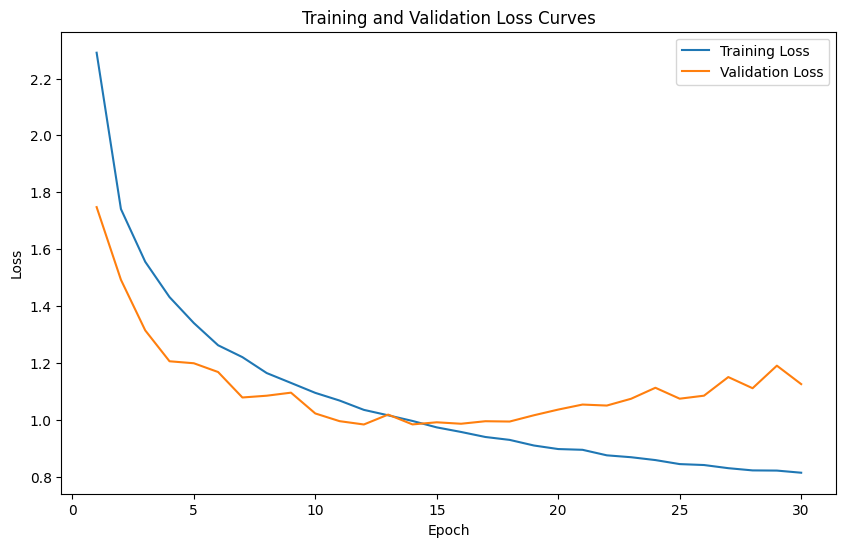

In [21]:
##################
# YOUR CODE HERE #
##################

# visualize model loss curves (both train and loss)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

The model Is doing better than before.

### Visualize the model weights

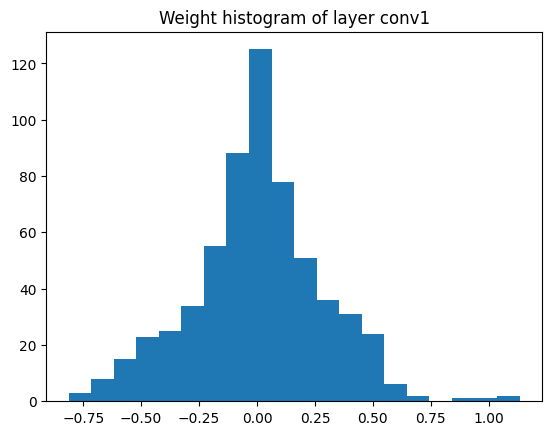

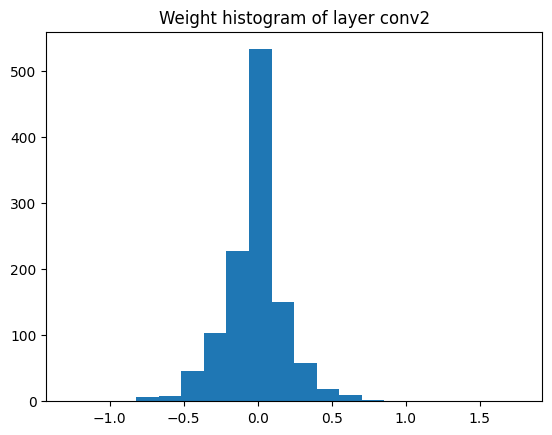

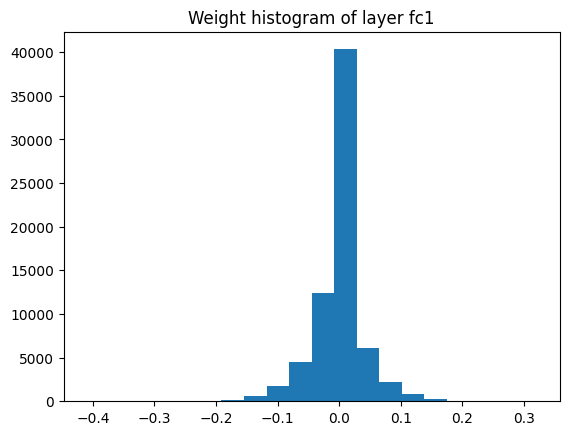

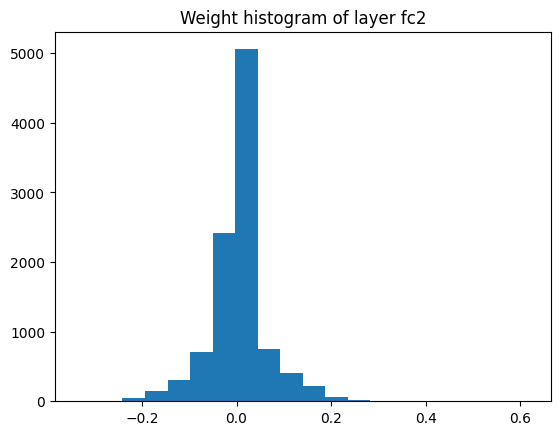

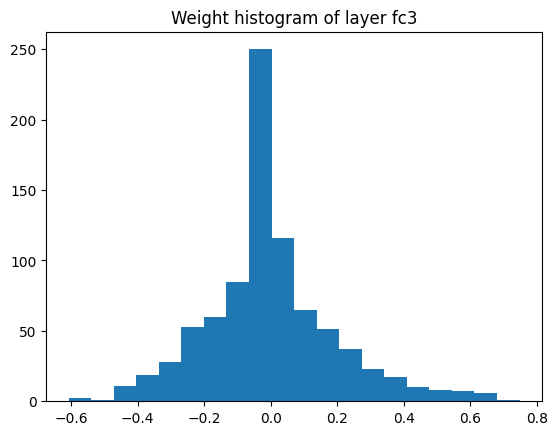

In [22]:
import matplotlib.pyplot as plt
for name, module in net.named_modules():
    if 'conv' in name or 'fc' in name:
        ##################
        # YOUR CODE HERE #
        ##################

        # extract weight from layers
        weight = []
        for p in module.parameters():
          weight.append(p.view(-1))
        weight = torch.cat(weight).cpu().detach().numpy()

        # Visualize the weights
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

# (d)

### L2 Regularization

In [23]:
INITIAL_LR = 0.01
net = SimpleCIFAR10Classifier().cuda()
MOMENTUM = 0.9
criterion = nn.CrossEntropyLoss()
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

##################
# YOUR CODE HERE #
##################

# set your own L2 regularization weight to 1e-3
REG = 1e-3
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)


# write training loops with L2 regularization and validation loops (Hint: similar to (a))

best_val_acc = 0
train_losses = []
val_losses = []

for i in range(0, EPOCHS):
    net.train()
    print("Epoch %d:" % i)
    total_examples = 0
    correct_examples = 0
    train_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        predictions = outputs.argmax(1)
        correct_examples += (predictions == targets).sum().item()
        total_examples += inputs.shape[0]

        train_loss += loss.item()

    current_learning_rate = optimizer.param_groups[0]['lr']
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))
    train_losses.append(avg_loss)

    net.eval()
    total_examples = 0
    correct_examples = 0
    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            predictions = outputs.argmax(1)
            correct_examples += (predictions == targets).sum().item()
            total_examples += targets.size(0)

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    val_losses.append(avg_loss)


    if avg_acc > best_val_acc:
        best_val_acc = avg_acc

        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'best_model_l2.bin'))
    print('')

print(f"Best validation accuracy (with L2 regularization): {best_val_acc:.4f}")

Epoch 0:
Training loss: 2.1647, Training accuracy: 0.1853
Validation loss: 1.8804, Validation accuracy: 0.3032
Saving ...

Epoch 1:
Training loss: 1.5972, Training accuracy: 0.4164
Validation loss: 1.4475, Validation accuracy: 0.4818
Saving ...

Epoch 2:
Training loss: 1.3629, Training accuracy: 0.5086
Validation loss: 1.2899, Validation accuracy: 0.5500
Saving ...

Epoch 3:
Training loss: 1.2426, Training accuracy: 0.5574
Validation loss: 1.2104, Validation accuracy: 0.5726
Saving ...

Epoch 4:
Training loss: 1.1354, Training accuracy: 0.5978
Validation loss: 1.1344, Validation accuracy: 0.6024
Saving ...

Epoch 5:
Training loss: 1.0522, Training accuracy: 0.6287
Validation loss: 1.0795, Validation accuracy: 0.6284
Saving ...

Epoch 6:
Training loss: 0.9838, Training accuracy: 0.6521
Validation loss: 1.0497, Validation accuracy: 0.6380
Saving ...

Epoch 7:
Training loss: 0.9214, Training accuracy: 0.6752
Validation loss: 0.9993, Validation accuracy: 0.6560
Saving ...

Epoch 8:
Trainin

In [24]:
##################
# YOUR CODE HERE #
##################

# load trained model weight
checkpoint_path = os.path.join(CHECKPOINT_FOLDER, 'best_model_l2.bin')
checkpoint = torch.load(checkpoint_path)

net = SimpleCIFAR10Classifier().cuda()
net.load_state_dict(checkpoint['state_dict'])
net.eval()

SimpleCIFAR10Classifier(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
##################
# YOUR CODE HERE #
##################

# write another loop to evaluate trained model performance on the test split
test_total_examples = 0
test_correct_examples = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        predictions = outputs.argmax(1)
        test_correct_examples += (predictions == targets).sum().item()
        test_total_examples += inputs.shape[0]

test_accuracy = test_correct_examples / test_total_examples
print("Test accuracy (with L2 regularization): %.4f" % test_accuracy)

Test accuracy (with L2 regularization): 0.6782


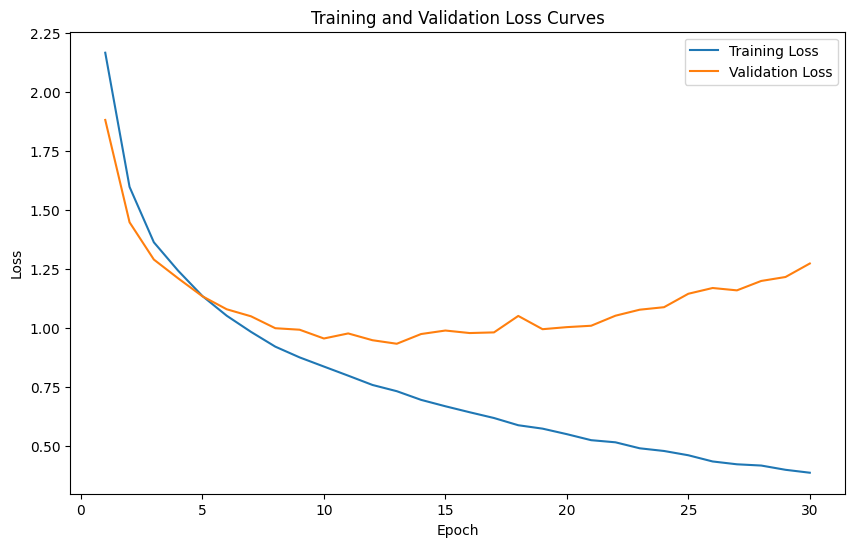

In [26]:
##################
# YOUR CODE HERE #
##################

# visualize model loss curves (both train and loss)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

### Visualize the model weights

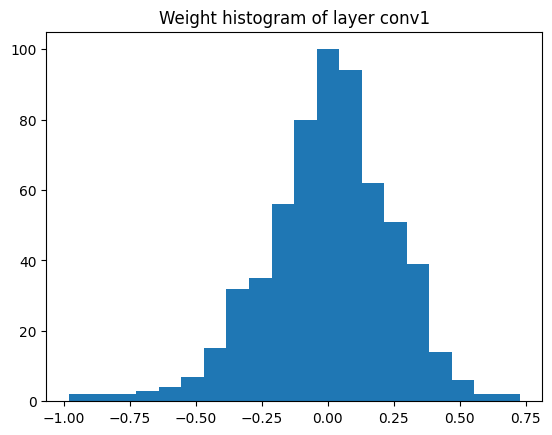

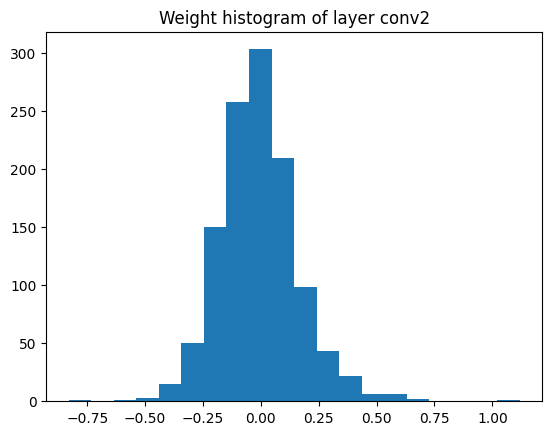

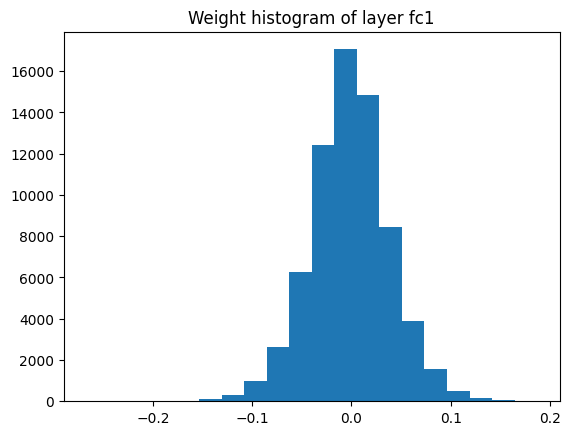

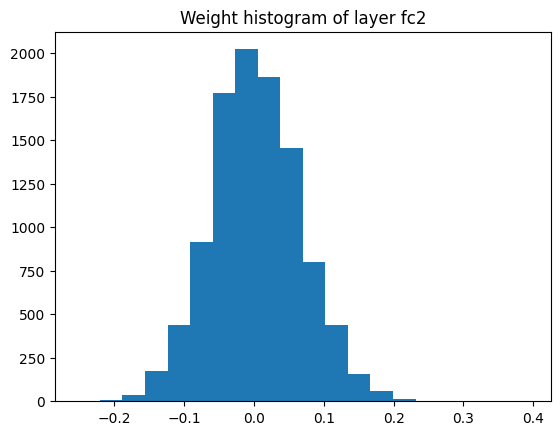

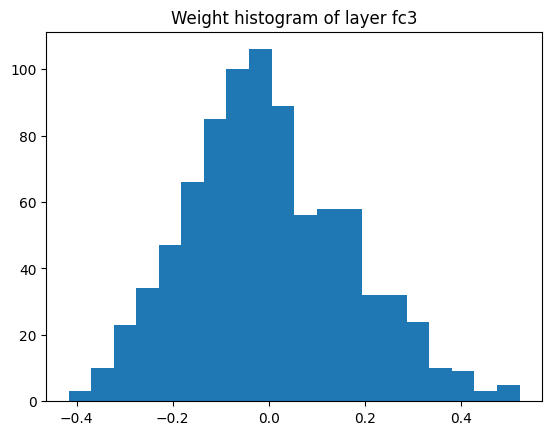

In [27]:
import matplotlib.pyplot as plt
for name, module in net.named_modules():
    if 'conv' in name or 'fc' in name:
        ##################
        # YOUR CODE HERE #
        ##################

        # extract weight from layers
        weight = []
        for p in module.parameters():
          weight.append(p.view(-1))
        weight = torch.cat(weight).cpu().detach().numpy()


        # Visualize the weights
        _ = plt.hist(weight, bins=20)
        plt.title("Weight histogram of layer "+name)
        plt.show()

# (e)

In [ ]:
# comment on the differences between L1 and L2 regularization.

Effects on Model Weights:

Histograms of L1 regularization reveals sparsity, where many weights are exactly 0. L1 regularization encourages the model to focus on a subset of the most important features, making the model simpler and potentially easier to interpret.
Histograms of L2 regularization shows that some weights are small but few are 0. L2 regularization primarily encourages the model to have smaller weight values without driving them to zero. It doesn't perform feature selection, and all features are retained.


Effects on Model Performance:

The loss-epoch curves show that both can prevent overfitting and L1 regularization prevents overfitting better than L2 regularization, this may be due to the fact that the dataset contains many irrelevant or redundant features, and L1 regularization effectively removes the influence of some of these features by setting their weights to zero, which helps simplify the model and reduces the likelihood of overfitting, as the model does not waste effort fitting irrelevant features. While L2 regularization helps prevent overfitting by smoothly controlling the magnitude of all weights. This may leave uncorrelated or redundant features.